<a href="https://colab.research.google.com/github/AnIsAsPe/ClassificadorCancerEsofago/blob/master/Notebooks/PerceptronClasificadorCancerEs%C3%B3fago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de tejido sano y tejido cancerígeno en imagenes microscópicas del esófago

![image.png](https://drive.google.com/uc?id=1K_j4CnOJeOmiROBiFwEW1M-kJkizrMk7)

## Paso 1. Cargar librerías y módulos requerdidos

In [1]:
import os            # módulo para manejar carpetas y archivos en nuestro ordenador
import random        # módulo para aleatorizar
import pickle        # módulo para respaldar objetos de pyhton como cadenas de bytes
                     # (serialización de objetos).

import numpy as np   # biblioteca para manejar matrices y operaciones de matrices
import pandas as pd  # biblioteca para manejar tablas de datos

#Skimage (Scikit-image): biblioteca para procesamiento de imágenes
from skimage import io  #Modulo para leer una imagen (librería para procesamiento de imagenes)

#Sklearn (Scikit-learn): biblioteca para machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

#Bibliotecas para gráficar y visualizar
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Paso 2. Lectura de datos.

### 2.1 Lectura de etiquetas (y)

In [3]:
#Leemos los datos

datos = pd.read_csv("https://raw.githubusercontent.com/AnIsAsPe/ClassificadorCancerEsofago/master/Datos/ClasesImagenes.csv", usecols=[1,2])


In [4]:
type(datos)

pandas.core.frame.DataFrame

In [5]:
datos.head()  #muestra los primeros cinco registros

,image_filename,class_number
0,im_4_0.png,0
1,im_21_0.png,0
2,im_9_0.png,0
3,im_8_0.png,0
4,im_15_0.png,0


In [6]:
#¿Con cuántas imagenes vamos a trabajar?

datos.shape[0]

5063

In [7]:
#¿cuántas imagenes tenemos de cada clase?

datos['class_number'].value_counts(sort=False)

0    1469
1    3594
Name: class_number, dtype: int64

Clase 0 corresponde a tejido sano y Clase 1 a tejido Cancerígeno

In [8]:
y = datos['class_number']  #Guardamos las etiquetas de las imagenes como serie de pandas


### 2.2 Lectura de imágenes (X)

**Lo primero que tenemos que hacer es descomprimir el archivo zip que guardamos en nuestro dirve**

In [ ]:

# !unzip -u "/content/drive/MyDrive/Datos/DatosCancer/CarpetaImagenes.zip" -d "/content/drive/MyDrive/Datos/DatosCancer/Unzip/"


In [9]:
datos['image_filename'].head()

0     im_4_0.png
1    im_21_0.png
2     im_9_0.png
3     im_8_0.png
4    im_15_0.png
Name: image_filename, dtype: object

**Vamos a leer la primera imagen, para ello además del nombre de la imagen, necesitamos añadir la ruta del directorio en donde se encuentra dicha imagen.**

In [10]:
nombre_archivo = 'im_4_0.png'

ruta = '/content/drive/MyDrive/Datos/DatosCancer/Unzip/'

imagen = io.imread(ruta  + nombre_archivo, as_gray=True)

In [11]:
# ¿qué tipo de objeto es imagen?
type(imagen)

numpy.ndarray

In [12]:
# ¿qué dimensiones tiene imagen?
imagen.shape

(260, 260)

In [13]:
imagen[180, 170:190]

array([0.22525176, 0.22525176, 0.22525176, 0.22525176, 0.21964078,
       0.21738588, 0.21738588, 0.21738588, 0.21738588, 0.21738588,
       0.21738588, 0.21738588, 0.21738588, 0.21429765, 0.21429765,
       0.21964078, 0.23142824, 0.23929412, 0.23142824, 0.23142824])

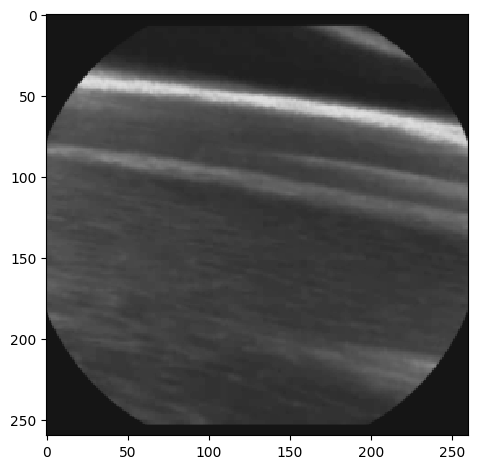

In [14]:
io.imshow(imagen)

**Ahora vamos a hacer lo mismo para todas las imagenes**

In [15]:
datos['image_filename']

0          im_4_0.png
1         im_21_0.png
2          im_9_0.png
3          im_8_0.png
4         im_15_0.png
            ...      
5058    im_114_55.png
5059      im_7_55.png
5060     im_52_55.png
5061     im_10_55.png
5062    im_111_55.png
Name: image_filename, Length: 5063, dtype: object

In [16]:
%time  img = datos['image_filename'].apply(lambda x: io.imread(ruta + x, as_gray=True))

CPU times: user 58.3 s, sys: 19.4 s, total: 1min 17s
Wall time: 28min 42s


<h2>Respaldamos el objeto img en un archivo pickle.<h2>

(si quieres conocer más sobre pickles de python, revisa [este enlace](https://programacion.net/articulo/los_pickles_de_python_1860))

In [ ]:
# # Guardar en archivo pickle
# ruta2 = '/content/drive/MyDrive/Datos/DatosCancer/' # directorio donde se guardará el
# pickle.dump(img, open (ruta2 + "imagenes_numpy.pkl", 'wb'))

In [ ]:
# # Leer archivo pickle
# ruta2 = '/content/drive/MyDrive/Datos/DatosCancer/'
# img = pickle.load(open(ruta2 + "imagenes_numpy.pkl", 'rb'))

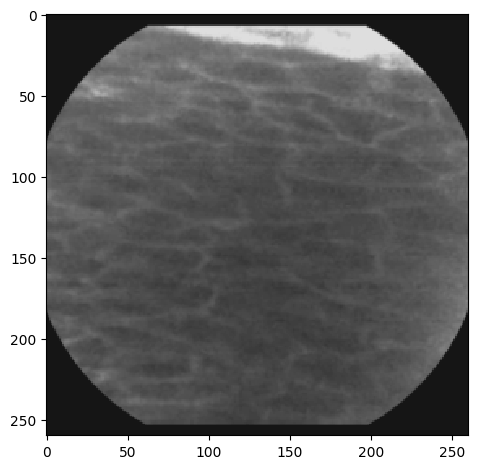

In [17]:
io.imshow(img[18])

- Dimensión 0: 260 renglones de pixeles de arriba a abajo
- Dimensión 1: 260 columnas de pixeles de izquierda a derecha


####  Transformar imágenes en vectores

In [20]:
type(img)  # Una serie de pandas es también una secuencia (como lo son las listas,
           # las tuplas, las cadenas de caracteres o los vectores de numpy)

pandas.core.series.Series

In [18]:
img.shape

(5063,)

In [19]:
img[0].shape  # Cada elemento de mi secuencia es una matriz de 260 x 260

(260, 260)

Lo primero es transformar la secuencia de matrices img en una sola matriz

In [21]:
IMG = np.stack(img, axis=0)  # Toma una secuencia de matrices y las apila a lo largo
                              # de un tercer eje para hacer una solo arreglo
IMG.shape

(5063, 260, 260)

Despues aplanar la matriz de 2D (260x260 pixeles) de cada imagen, para obtener un vector por imagen.

In [22]:
X = IMG.reshape( 5063, -1)
X.shape

(5063, 67600)

##### Visualizamos ejemplos de ambas clases de imagenes

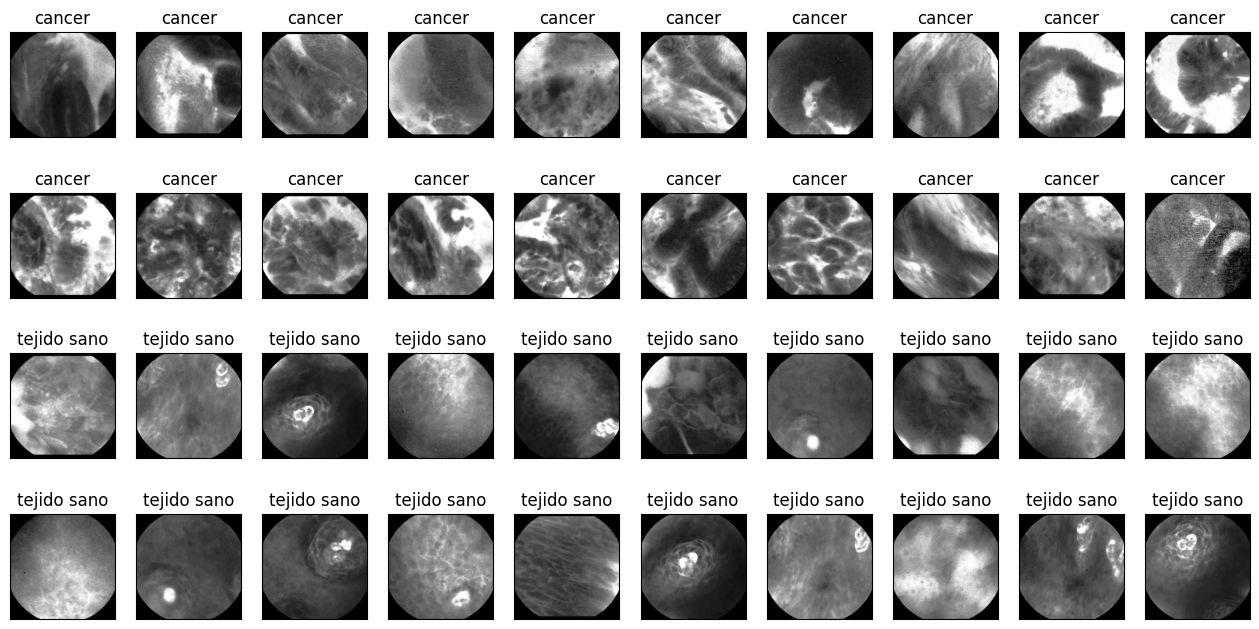

In [24]:
#El método GroupBy de Pandas separa un data frame en varios data frames
porClase = datos.groupby('class_number')

#elije al azar n muestras de cada subconjunto y guarda la posición de las figuras elegidas en una lista
n = 20
c = random.sample(porClase.get_group(1).index.tolist(), n) # indices de las imagenes cancerígenas seleccionadas
s = random.sample(porClase.get_group(0).index.tolist(), n) # indices de las imagenes sanas seleccionadas

# Grafica 20 imágenes aleatorias de tejido con cáncer y 20 de tejido sano

fig = plt.figure(figsize=(16, 8))
columns = 10
rows = 4
for i in range(0, columns * rows):
    fig.add_subplot( rows, columns, i+1)
    if i < 20:
        plt.imshow(img[c[i]], cmap='Greys_r')
        plt.title('cancer')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow(img[s[i-20]], cmap='Greys_r')
        plt.title('tejido sano')
        plt.xticks([])
        plt.yticks([])
plt.show()

## Paso 3. Construcción de nuestro clasificador

### 3.1  Crear subconjuntos de entrenamiento y prueba



In [25]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3,
                                                    shuffle=True, random_state=0)

In [26]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Training set")
print("X: ", X_train.shape)
print("y: ", y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print('Tejido Sano:        ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')


print("Test set")
print("X: ", X_test.shape)
print("y: ", y_test.shape)
unique, counts = np.unique(y_test, return_counts=True)
print('Tejido Sano:         ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')

Training set
X:  (3544, 67600)
y:  (3544,)
Tejido Sano:         1043 
Displasia o Cáncer:  2501 

Test set
X:  (1519, 67600)
y:  (1519,)
Tejido Sano:          426 
Displasia o Cáncer:  1093 



### 3.2  Entrenamiento



In [42]:
model = Perceptron(max_iter=1000,   random_state=0, verbose=False).fit(X_train,y_train)

print("Iterations: ", model.n_iter_)

Iterations:  44


In [32]:
#Guardamos los coeficientes del modelo como beta

beta = model.coef_
beta.shape

(1, 67600)

In [35]:
beta[0, 50310:50320]

array([ -1.92002706,  26.43550275,  48.33832196,  60.5412651 ,
        36.79920392,  20.46658157,  -2.35208118, -16.18895686,
       -16.80207686,   4.81493412])

In [33]:
model.intercept_


array([-42.])

### 3.3 Pedicción

In [40]:
y_predict = model.predict(X_test)  #pasa cada una de las imágenes de X_test por el modelo
y_predict[:20]

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1])

### 3.4 Evaluación

In [41]:
y_test.to_numpy()[:20]

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1])

In [44]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 95.49%
Precisión conjunto prueba: 90.19%


In [49]:
data = {'Y_Real':  y_test,
        'Y_Prediccion':y_predict
        }
df = pd.DataFrame(data)
df

,Y_Real,Y_Prediccion
3284,0,0
142,1,1
2625,1,1
2066,1,1
72,0,1
...,...,...
1569,1,1
5057,1,1
1422,0,0
2044,1,1


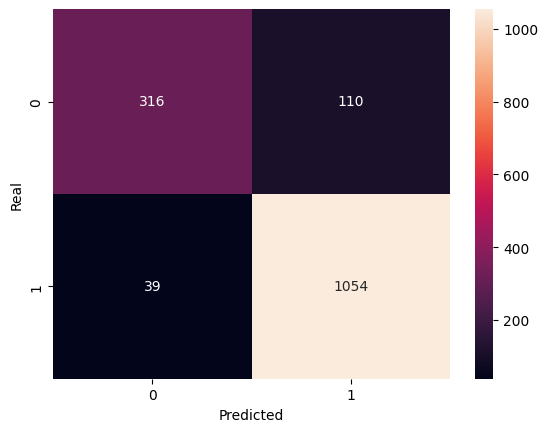

In [50]:
#Matriz de confusión

confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

## Paso 4. Entrenamiento de perceptron utilizando margen

In [51]:
model2 = Perceptron(max_iter=1000,  random_state=0, verbose=False,
                    penalty='l2',  alpha=0.0001)
model2.fit(X_train,y_train)

print("Precisión conjunto entrenamiento: %.2f%%" % (model2.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model2.score(X_test, y_test)*100.0))


Precisión conjunto entrenamiento: 77.48%
Precisión conjunto prueba: 77.49%


In [ ]:
model3 = Perceptron(max_iter=1000,  random_state=0, verbose=False,
                    penalty='l2', alpha=0.000005)

model3.fit(X_train,y_train)

print("Precisión conjunto entrenamiento: %.2f%%" % (model3.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model3.score(X_test, y_test)*100.0))

In [ ]:
model4 = Perceptron(max_iter=1000,  random_state=0, verbose=False,
                    penalty='l2', alpha=0.000001)
model4.fit(X_train,y_train)

print("Precisión conjunto entrenamiento: %.2f%%" % (model4.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model4.score(X_test, y_test)*100.0))